In [1]:
%matplotlib inline
import simtk.unit as units
import simtk.openmm as mm
import simtk.openmm.app as app
import parmed
import matplotlib.pyplot as plt
from parmed.charmm import CharmmParameterSet, CharmmPsfFile
from parmed.topologyobjects import DihedralType, DihedralTypeList, Dihedral
import torsionfit.TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from pymc import MCMC
import torsionfit.sqlite_plus as db
import numpy as np
import mdtraj as md
import seaborn
import pymbar
import corner

In [2]:
param = CharmmParameterSet('toy.str')
struct = CharmmPsfFile('toy.psf')
pdb = app.PDBFile('toy.pdb')
topology = md.load_psf('toy.psf')

In [3]:
# replace ('CG331', 'CG321', 'CG321', 'CG331') torsion with k1 = 10. Everything else is 0
# First save the current value to replace with later
dih_type = ('CG331', 'CG321', 'CG321', 'CG331')
original_torsion = param.dihedral_types[dih_type]
dih_tlist = DihedralTypeList()
#dih_tlist.append(DihedralType(10.00, 1, 0.00, 1.00, 1.00))
#dih_tlist.append(DihedralType(10.00, 2, 0.00, 1.00, 1.00))
#dih_tlist.append(DihedralType(10.00, 3, 0.00, 1.00, 1.00))
dih_tlist.append(DihedralType(10.00, 4, 0.00, 1.00, 1.00))
#dih_tlist.append(DihedralType(10.00, 6, 0.00, 1.00, 1.00))
param.dihedral_types[dih_type] = dih_tlist

# parameterize structure 
struct.load_parameters(param, copy_parameters=False)
struct.positions = pdb.positions

# Get Dihedral to do torsion drive
for dihedral in struct.dihedrals:
    if dihedral.atom1.type == 'CG331' and dihedral.atom4.type == 'CG331':
        dihedral_to_scan = dihedral
# Get Bond length in nm
for bond in struct.bonds:
    if bond.atom1.type == bond.atom2.type:
        length = units.Quantity(value=bond.type.req * 0.1, unit=units.nanometers) # convert to nm
# Get Angle in radians\n",
for angle in struct.angles:
    if angle.atom1.type == angle.atom2.type:
        theta = units.Quantity(value=angle.type.theteq * (np.pi/180.0), unit=units.radians)

In [4]:
def spher2cart(r, theta, phi):
    """convert spherical to cartesian corrdinates
    Paramters:
    r: bond length
    theta: bond angle
    phi: dihedral angle
    
    returns:
    cartesian coordinates
    """
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]


In [5]:
# Generate positions for torsion scan
n_increments = 13
n_atoms = 4
phis = np.arange(-np.pi/2, +np.pi/2, (np.pi)/n_increments)
positions = np.zeros((len(phis), n_atoms, 3))
atom1_coords = spher2cart(length.value_in_unit(units.nanometer), theta.value_in_unit(units.radian), phis[0])
for i, phi in enumerate(phis):
    atom3_coords = spher2cart(length.value_in_unit(units.nanometer), theta.value_in_unit(units.radian), phi)
    atom3_coords[-1] = abs(atom3_coords[-1]) + length._value
    positions[i] = [atom1_coords,
                [0.000, 0.000, 0.000],
                [0.000, 0.000, length._value],
                atom3_coords]
positions = units.Quantity(value=positions, unit=units.nanometer) # put units back in 

In [6]:
positions[12]

Quantity(value=array([[  8.49078802e-18,  -1.38665091e-01,  -6.46605940e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.53000000e-01],
       [  3.31847285e-02,   1.34635736e-01,   2.17660594e-01]]), unit=nanometer)

[ 83.71363349  65.64146249  27.03696502   1.24942785  10.55594379
  46.91688819  78.9211136   78.9211136   46.91688819  10.55594379
   1.24942785  27.03696502  65.64146249] kJ/mol


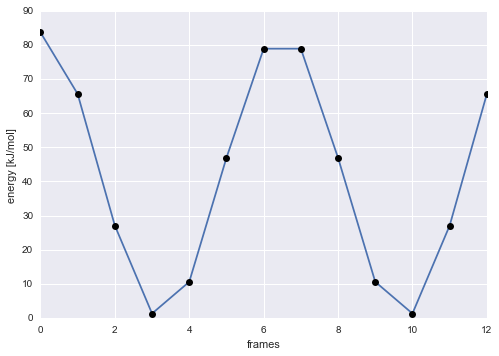

In [7]:
qm_energy = units.Quantity(value=np.zeros((len(positions))), unit=units.kilojoules_per_mole)
platform = mm.Platform.getPlatformByName('Reference')
integrator = mm.VerletIntegrator(0.004*units.picoseconds)
system = struct.createSystem()
context = mm.Context(system, integrator, platform)
for i, conf in enumerate(positions):
    context.setPositions(conf)
    state = context.getState(getEnergy=True)
    qm_energy[i] = state.getPotentialEnergy() 
    state.getPotentialEnergy()
plt.plot(qm_energy)
plt.plot(qm_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.savefig('qm.pdf')
print qm_energy

In [8]:
# retrun original dihedral to param
param.dihedral_types[dih_type] = original_torsion

# create torsionfit.TorsionScanSet
torsions = np.zeros((len(positions), 4))
torsions[:] = [1,2,3,4]
direction = None
steps = None
scan_set = ScanSet.TorsionScanSet(positions.value_in_unit(units.nanometers), topology, struct,
                                  torsions, direction, steps, qm_energy.value_in_unit(units.kilojoules_per_mole))

In [9]:
# create TorsionFitModel
model = Model.TorsionFitModel(param, 'toy.str', scan_set, platform=platform, param_to_opt=[dih_type])
sampler = MCMC(model.pymc_parameters)
sampler.sample(iter=1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 17.4 sec

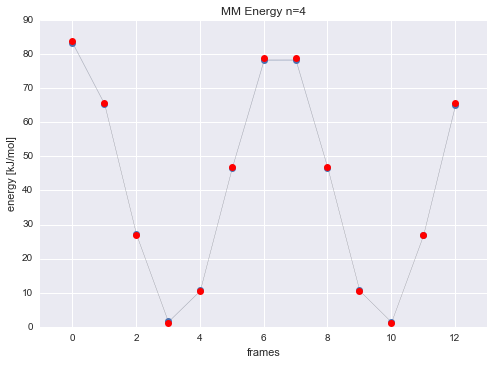

In [10]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(qm_energy, 'o', color='r')
plt.title('MM Energy n=4')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.savefig('n_4_mm_fit.pdf')

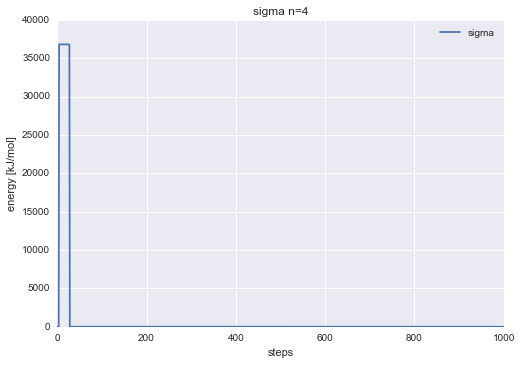

In [13]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.title('sigma n=4')

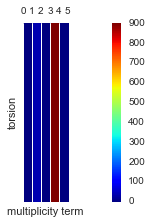

In [14]:
import torsionfit.plots as plots
plots.marg_mult(model, sampler, 1000, 100, 'test_2.png')


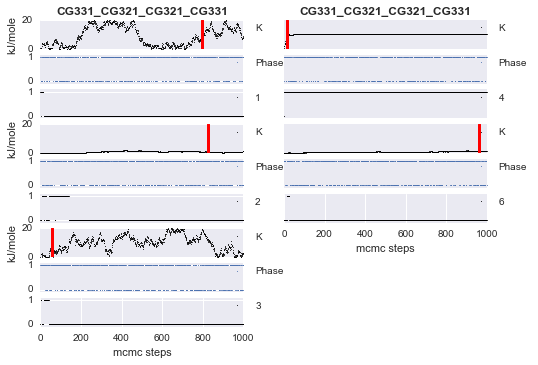

In [15]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0)

In [16]:
data = np.stack((sampler.CG331_CG321_CG321_CG331_1_K.trace[100:],
                sampler.CG331_CG321_CG321_CG331_2_K.trace[100:], sampler.CG331_CG321_CG321_CG331_3_K.trace[100:], 
                sampler.CG331_CG321_CG321_CG331_4_K.trace[100:], sampler.CG331_CG321_CG321_CG331_6_K.trace[100:]), axis=1)

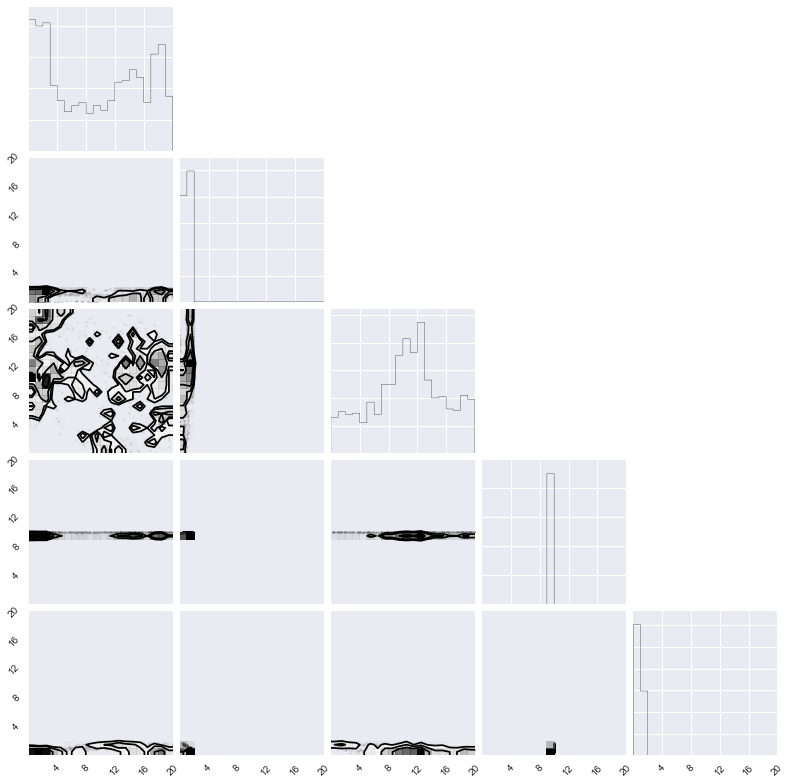

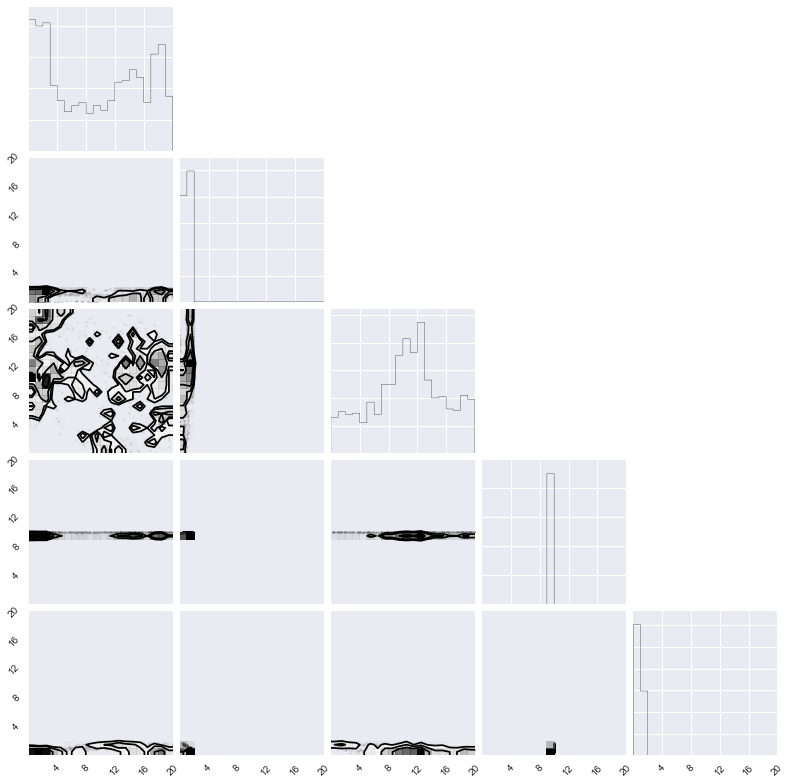

In [17]:
corner.corner(data, plot_countours=False, range=[(0, 20), (0,20), (0,20), (0,20), (0,20)])